### Univariate profiles

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
from scipy.stats import sem
from sklearn.feature_selection import f_classif
from fmri_decoder.data import SurfaceData
import os
import sys
import matplotlib.pyplot as plt
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from src.data import Data
plt.style.use(os.path.join(module_path, "src", "default.mplstyle"))

N_LAYER = 11

In [2]:
# parameters
contrast = "vaso"  # ge, se, vaso
metric = "tsnr"  # psc, cnr, tsnr
nmax = 200
DIR_OUT = "/data/pt_01880/"

In [3]:
def get_label(subj):
    # get label and hemisphere
    data = Data(subj, [])
    surf_data = SurfaceData(data.file_layer, None, data.file_label)

    label_left = surf_data.load_label_intersection("lh")
    label_right = surf_data.load_label_intersection("rh")

    hemi = np.zeros(len(label_left)+len(label_right))
    hemi[len(label_left):] = 1
    label = np.append(label_left, label_right)

    return label, hemi

def select_features(dtf, label, hemi):
    features = dtf.columns[2:]
    
    X = np.array(dtf.loc[:, features])
    y = np.array(dtf.loc[:, "label"])

    f_statistic = f_classif(X, y)[0]
    index = np.arange(len(features))
    index_sorted = np.array(
                [x for _, x in sorted(zip(f_statistic, index), reverse=True)]
            )
    index_sorted = index_sorted[: nmax]

    label_selected = label[index_sorted]
    hemi_selected = hemi[index_sorted]

    return label, hemi

In [4]:
subjs = ["p1", "p2", "p3", "p4", "p5"]
sessions = {}
sessions["p1"] = {}
sessions["p1"]["ge"] = ["GE_EPI3", "GE_EPI4"]
sessions["p1"]["se"] = ["SE_EPI1", "SE_EPI2"]
sessions["p1"]["vaso"] = ["VASO1", "VASO2"]
sessions["p2"] = {}
sessions["p2"]["ge"] = ["GE_EPI1", "GE_EPI2"]
sessions["p2"]["se"] = ["SE_EPI1", "SE_EPI2"]
sessions["p2"]["vaso"] = ["VASO2", "VASO3"]
sessions["p3"] = {}
sessions["p3"]["ge"] = ["GE_EPI2", "GE_EPI3"]
sessions["p3"]["se"] = ["SE_EPI1", "SE_EPI2"]
sessions["p3"]["vaso"] = ["VASO1", "VASO3"]
sessions["p4"] = {}
sessions["p4"]["ge"] = ["GE_EPI1", "GE_EPI2"]
sessions["p4"]["se"] = ["SE_EPI1", "SE_EPI2"]
sessions["p4"]["vaso"] = ["VASO1", "VASO2"]
sessions["p5"] = {}
sessions["p5"]["ge"] = ["GE_EPI1", "GE_EPI2"]
sessions["p5"]["se"] = ["SE_EPI1", "SE_EPI2"]
sessions["p5"]["vaso"] = ["VASO1", "VASO2"]

res = np.zeros((N_LAYER, 2 * len(subjs)))
for layer in range(N_LAYER):
    counter = 0
    for subj in subjs:
        label, hemi = get_label(subj)
        for session in sessions[subj][contrast]:
            data = Data(subj, session)
            # load dataframe
            dtf = pd.read_parquet(data.get_sample_data(layer))
            N_BATCH = len(np.unique(dtf["batch"]))

            arr = []
            label_selected, hemi_selected = select_features(dtf, label, hemi)

            if metric == "tsnr":
                arr_left = data.get_tsnr("lh", layer)
                arr_right = data.get_tsnr("rh", layer)
            elif metric == "cnr":
                arr_left = data.get_cnr("lh", layer)
                arr_right = data.get_cnr("rh", layer)
            elif metric =="psc":
                arr_left = data.get_psc("lh", layer)
                arr_right = data.get_psc("rh", layer)
            else:
                ValueError("Unknown metric!")

            arr.extend(arr_left[label_selected[hemi_selected==0]])
            arr.extend(arr_right[label_selected[hemi_selected==1]])

            res[layer, counter] = np.mean(arr)
            counter += 1

np.save(Path(DIR_OUT) / f"{metric}_{contrast}.npy", res)


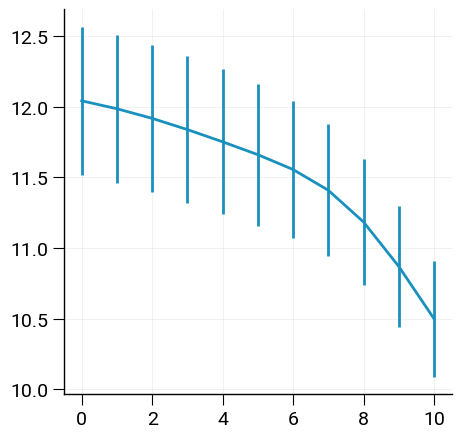

In [5]:
file_in = [Path("/data/pt_01880") / f"{metric}_{contrast}.npy"]

fig, ax = plt.subplots(figsize=(5, 5))
for f in file_in:
    res = np.load(f)
    res_mean = np.mean(res, axis=1)
    res_sem = sem(res, axis=1)
    plt.errorbar(x=np.arange(N_LAYER), y=res_mean, yerr=res_sem)

#plt.xlabel(r'Gaussian filter size $t$')
plt.locator_params(axis='x', nbins=10)
plt.locator_params(axis='y', nbins=10)

# write output
#if DIR_OUT:
#    dir_out = Path(DIR_OUT)
#    dir_out.mkdir(exist_ok=True)
#    file_out = dir_out / "filter_sizes.svg"
#    fig.savefig(file_out, dpi=300, bbox_inches="tight", transparent=True, format="svg")